# 项目：搭建一个数字识别项目

## 连接 mnist 的字符来合成数据

通过连接[MNIST](http://yann.lecun.com/exdb/mnist/)的字符来合成数据来训练这个模型。为了快速导入数据集，我们可以使用 [Keras Datasets](https://keras.io/datasets/#mnist-database-of-handwritten-digits) [中文文档](http://keras-cn.readthedocs.io/en/latest/other/datasets/#mnist)。

### 载入 mnist

In [18]:
from keras.datasets import mnist

(X_raw, y_raw), (X_raw_test, y_raw_test) = mnist.load_data()

n_train, n_test = X_raw.shape[0], X_raw_test.shape[0]

### 可视化 mnist

我们可以通过 matplotlib 来可视化我们的原始数据集。

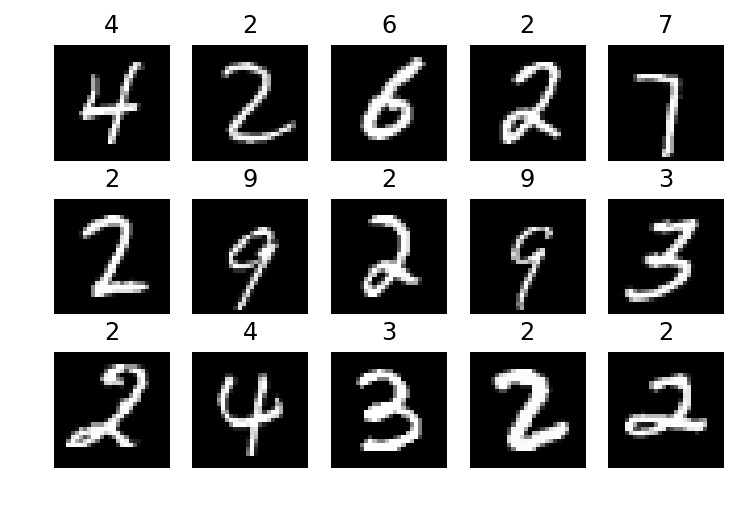

In [60]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

for i in range(15):
    plt.subplot(3, 5, i+1)
    index = random.randint(0, n_train-1)
    plt.title(str(y_raw[index]))
    plt.imshow(X_raw[index], cmap='gray')
    plt.axis('off')

### 合成数据

随机取随机（1-5）张图片，然后将它们拼接成新的图片。

设置20%的数据作为验证集，以保证模型没有过拟合。

In [390]:
import numpy as np
from sklearn.model_selection import train_test_split

n_class, n_len, width, height = 11, 5, 28, 28

def generate_dataset(X, y):
    X_len = X.shape[0]
    
    X_gen = np.zeros((X_len, height, width*n_len, 1), dtype=np.uint8)
    y_gen = [np.zeros((X_len, n_class), dtype=np.uint8) for i in range(n_len)]
    
    # 随机取1~5个数字，并拼接成新的图片
    for m in range(X_len):
        num_1 = random.randint(1, 5)
        for i in range(num_1):
            j = random.choice(range(X_len))
            X_gen[m, :, i*height: (i+1)*height, 0] = X[j]
            y_gen[i][m][y[j]] = 1
        for i in range(num_1, n_len):
            y_gen[i][m][10] = 1
    
    return X_gen, y_gen

X_raw_train, X_raw_valid, y_raw_train, y_raw_valid = train_test_split(X_raw, y_raw, test_size=0.2, random_state=1)

X_train, y_train = generate_dataset(X_raw_train, y_raw_train)
X_valid, y_valid = generate_dataset(X_raw_valid, y_raw_valid)
X_test, y_test = generate_dataset(X_raw_test, y_raw_test)


(10000, 28, 140, 1)
[[0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]]


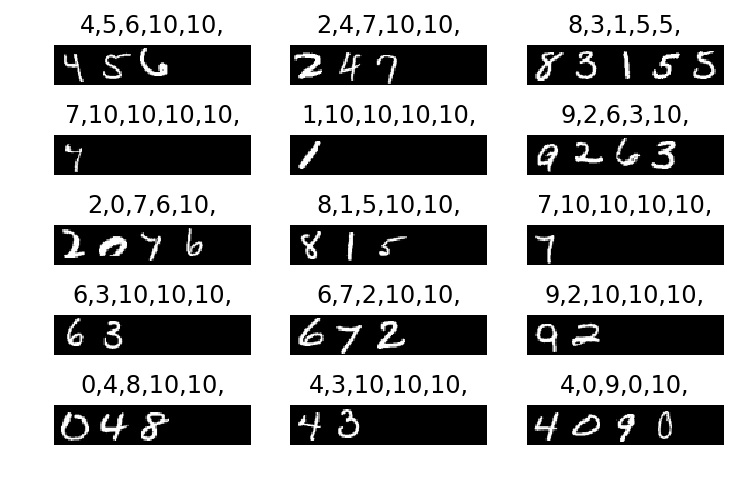

In [266]:
# 显示生成的图片
for i in range(15):
    plt.subplot(5, 3, i+1)
    index = random.randint(0, n_test-1)
    title = ''
    for j in range(n_len):
        title += str(np.argmax(y_test[j][index])) + ','
    
    plt.title(title)
    plt.imshow(X_test[index][:,:,0], cmap='gray')
    plt.axis('off')

### 设计并实现一个能够识别数字序列的深度学习模型。

可以在深度网络上使用五个分类器，但此时有必要准备一个额外的“空白”的字符，以处理相对较短的数字序列。

有很多方面可以考虑：

- 模型可以基于深度神经网络或者是卷积神经网络。
- 可以尝试是否在每个分类器间共享权值。
- 还可以在深度神经网络中使用循环网络来替换其中的分类层，并且将数字序列里的数字一个一个地输出。

在使用 Keras 搭建模型的时候，可以使用 [泛型模型](http://keras-cn.readthedocs.io/en/latest/models/model/) 的方式来搭建多输出模型。

In [391]:
import keras
from keras.models import Model
from keras.layers import *
from keras.optimizers import RMSprop

batch_size = 128
n_class = 11
epochs = 5

X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_valid /= 255
X_test /= 255


print X_train.shape

digit_input = Input(shape=(28, 140, 1))
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(digit_input)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

x = [Dense(n_class, activation='softmax', name='num%d'%(i+1))(x) for i in range(5)]

model = Model(inputs = digit_input, output = x)

model.summary()

model.compile(optimizer = RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])




(48000, 28, 140, 1)


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_514 (InputLayer)           (None, 28, 140, 1)    0                                            
____________________________________________________________________________________________________
conv2d_74 (Conv2D)               (None, 26, 138, 16)   160                                          
____________________________________________________________________________________________________
conv2d_75 (Conv2D)               (None, 24, 136, 32)   4640                                         
____________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D)  (None, 12, 68, 32)    0                                            
___________________________________________________________________________________________

### 可视化你的网络模型

参考链接：[visualization](http://keras-cn.readthedocs.io/en/latest/other/visualization/)

可以是 PNG 格式，也可以是 SVG 格式。

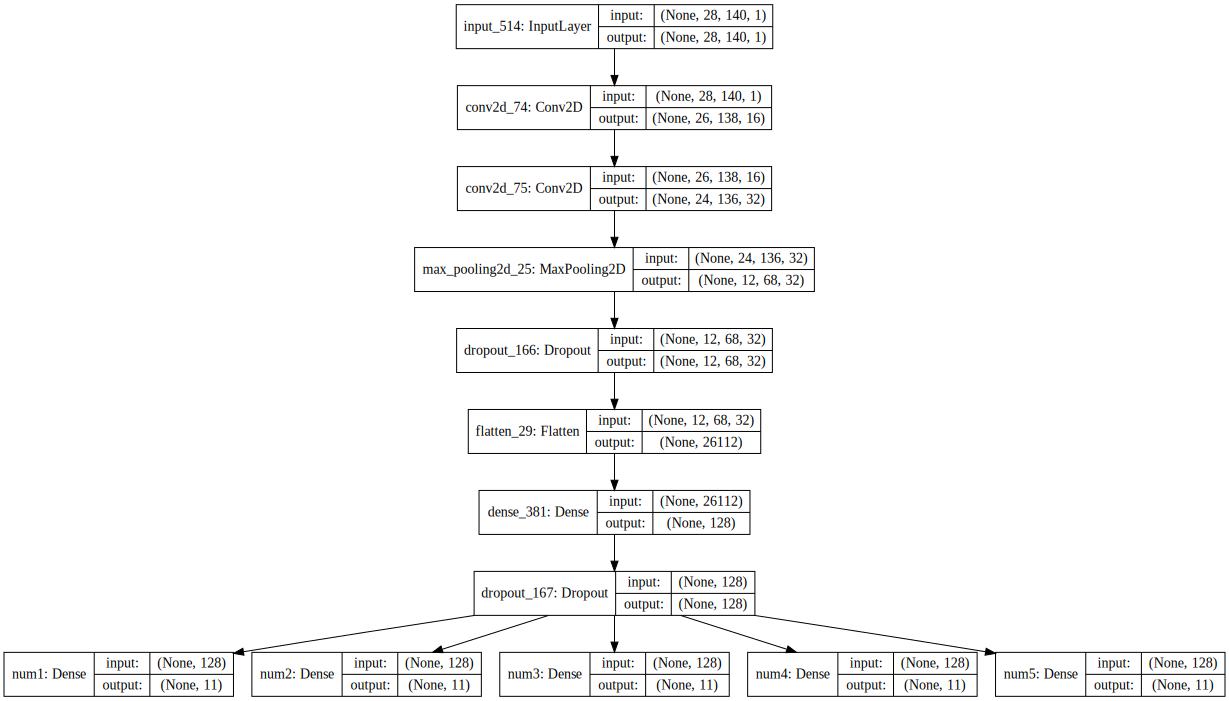

In [392]:

from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.display import Image, SVG


# 可视化你的模型

figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

plot_model(model, to_file='model.png', show_shapes=True)


### 训练网络模型

训练模型时，需要设置训练集和验证集。

In [393]:
# 训练你的模型

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
                    validation_data=(X_valid, y_valid))



Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 408s - loss: 2.6110 - num1_loss: 0.6710 - num2_loss: 0.6254 - num3_loss: 0.5542 - num4_loss: 0.4508 - num5_loss: 0.3096 - num1_acc: 0.7820 - num2_acc: 0.7997 - num3_acc: 0.8244 - num4_acc: 0.8596 - num5_acc: 0.9070 - val_loss: 0.6024 - val_num1_loss: 0.1546 - val_num2_loss: 0.1468 - val_num3_loss: 0.1211 - val_num4_loss: 0.0986 - val_num5_loss: 0.0813 - val_num1_acc: 0.9548 - val_num2_acc: 0.9567 - val_num3_acc: 0.9663 - val_num4_acc: 0.9722 - val_num5_acc: 0.9761

### 计算模型准确率

刚才得到了模型每个数字的准确率，现在来计算整体准确率，按照完全预测正确数字序列的标准来计算。

比如 1,2,3,10,10 预测成了 1,2,10,10,10 算错，而不是算对了80%。

In [394]:
def evaluate(model):
    # 按照错一个就算错的规则计算准确率
    
    n = 0
    
    for i in range(n_test):
        y_pred_list = []
        y_test_list = []
        y_pred = model.predict(X_test[i].reshape(1, height, width*n_len, 1))
        y_test_new = [y_test[x][i] for x in range(n_len)]
        for j in range(n_len):
            y_pred_list.append(np.argmax(y_pred[j]))
            y_test_list.append(np.argmax(y_test_new[j]))
        if y_pred_list == y_test_list:
            n += 1
            
        #print y_test_list, y_pred_list
    acc = float(n)/n_test
            
    print acc

evaluate(model)

0.9199


### 预测值可视化

将模型的预测结果和真实值画出来，观察真实效果。

(-0.5, 139.5, 27.5, -0.5)

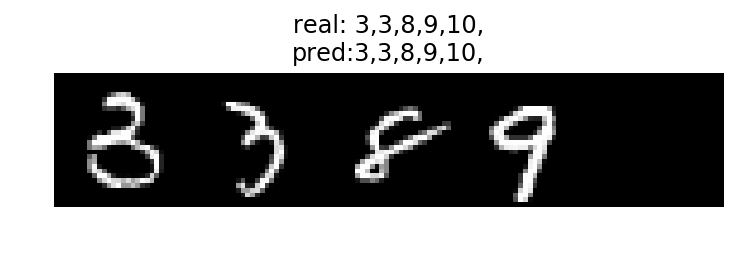

In [371]:
def get_result(result):
    # 将 one_hot 编码解码
    resultstr = ''
    for i in range(n_len):
        resultstr += str(np.argmax(result[i])) + ','
    return resultstr

index = random.randint(0, n_test-1)
y_pred = model.predict(X_test[index].reshape(1, height, width*n_len, 1))

plt.title('real: %s\npred:%s'%(get_result([y_test[x][index] for x in range(n_len)]), get_result(y_pred)))
plt.imshow(X_test[index,:,:,0], cmap='gray')
plt.axis('off')

### 保存模型

模型达到满意的效果以后，需要将模型的权值和结构保存，以便下次调用。

In [396]:
model.save_weights('model.h5')
with open('model.json', 'w') as f:
    f.write(model.to_json())